### 설정
1. 파이썬 3.10 이상 설치 (64 bit)
2. 가상환경 생성
3. 파일 경로 설정

In [9]:
import os
import json
import random
import shutil
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

In [15]:
# ====== 경로 설정 ======
BASE_DIR   = r"C:\소아복부합성데이터"
TRAIN_DIR  = os.path.join(BASE_DIR, "Training")
VAL_DIR    = os.path.join(BASE_DIR, "Validation")
OUTPUT_DIR = os.path.join(BASE_DIR, "Processed")

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, "masks"),  exist_ok=True)

# ====== JSON 수집 함수 ======
def collect_json_files(base_dir):
    files = []
    for root, _, fnames in os.walk(base_dir):
        for f in fnames:
            if f.lower().endswith(".json"):
                files.append(os.path.join(root, f))
    return files

# ====== Training/Validation JSON 모으기 ======
train_jsons = collect_json_files(TRAIN_DIR)
val_jsons   = collect_json_files(VAL_DIR)

print(f"[INFO] Training 폴더 JSON 개수: {len(train_jsons)}")
print(f"[INFO] Validation 폴더 JSON 개수: {len(val_jsons)}")


[INFO] Training 폴더 JSON 개수: 8000
[INFO] Validation 폴더 JSON 개수: 1000


In [12]:
import os
import json
import random
import shutil
from PIL import Image, ImageDraw
from tqdm import tqdm

# 1️⃣ 경로 설정
BASE_DIR   = r"C:\소아복부합성데이터"
TRAIN_DIR  = os.path.join(BASE_DIR, "Training")
VAL_DIR    = os.path.join(BASE_DIR, "Validation")
OUTPUT_DIR = os.path.join(BASE_DIR, "Processed")

# 출력 폴더 생성
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, "masks"),  exist_ok=True)

# 2️⃣ JSON 파일 수집 함수
def collect_json_files(base_dir):
    files = []
    for root, _, fnames in os.walk(base_dir):
        for f in fnames:
            if f.lower().endswith(".json"):
                files.append(os.path.join(root, f))
    return files

# 3️⃣ 이미지 경로 매칭 함수
def get_image_path_from_json(json_path, filename):
    """
    Training: TL_xxx → TS_xxx
    Validation: VL_xxx → VS_xxx
    """
    parent = os.path.dirname(json_path)       # ...\Validation\VL_...
    parent_parent = os.path.dirname(parent)   # ...\Validation

    folder_name = os.path.basename(parent)    # VL_1.질환_1.선천성유문협착증
    if folder_name.startswith("TL"):
        img_folder = folder_name.replace("TL", "TS", 1)
    elif folder_name.startswith("VL"):
        img_folder = folder_name.replace("VL", "VS", 1)
    else:
        raise ValueError(f"알 수 없는 라벨 폴더 이름: {folder_name}")

    # Validation의 경우 VS_* 폴더는 같은 Validation 폴더 안에 있을 것
    img_dir = os.path.join(parent_parent, img_folder)
    img_path = os.path.join(img_dir, filename)

    if not os.path.exists(img_path):
        # 혹시 하위 폴더 구조가 다를 수 있으니 os.walk로 fallback 검색
        for root, _, files in os.walk(parent_parent):
            if filename in files:
                return os.path.join(root, filename)
        return None

    return img_path


# 4️⃣ 마스크 변환 함수
def json_to_mask(json_path, mask_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    w, h = data.get("imageWidth"), data.get("imageHeight")
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)

    for shape in data["shapes"]:
        points = [tuple(p) for p in shape["points"]]
        draw.polygon(points, outline=1, fill=1)

    mask.save(mask_path)

# 5️⃣ JSON 수집 & Split
train_jsons = collect_json_files(TRAIN_DIR)
val_jsons   = collect_json_files(VAL_DIR)

random.shuffle(train_jsons)
train_files = train_jsons[:7200]
val_files   = train_jsons[7200:]
test_files  = val_jsons  # Validation 전체를 Test로 사용

splits = {"train": train_files, "val": val_files, "test": test_files}

# 6️⃣ 변환 실행
for split, files in splits.items():
    print(f"\n🔹 {split.upper()} 변환 시작 ({len(files)}개)")
    for idx, json_path in enumerate(files, 1):
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        filename = data["filename"]

        # 이미지 경로 찾기
        img_path = get_image_path_from_json(json_path, filename)
        if img_path is None:
            print(f"    ❌ 매칭 실패: {json_path} → {filename}")
            continue
        else:
            print(f"    🔎 매칭 성공: {json_path} → {img_path}")

        out_img  = os.path.join(OUTPUT_DIR, split, "images", filename)
        out_mask = os.path.join(OUTPUT_DIR, split, "masks", filename)

        shutil.copy(img_path, out_img)
        json_to_mask(json_path, out_mask)
        print(f"    ✅ {split} ({idx}) 변환 완료 → {filename}")



🔹 TRAIN 변환 시작 (7200개)
    🔎 매칭 성공: C:\소아복부합성데이터\Training\TL_1.질환_4.변비\4_2101.json → C:\소아복부합성데이터\Training\TS_1.질환_4.변비\4_2101.png
    ✅ train (1) 변환 완료 → 4_2101.png
    🔎 매칭 성공: C:\소아복부합성데이터\Training\TL_1.질환_2.기복증\2_1553.json → C:\소아복부합성데이터\Training\TS_1.질환_2.기복증\2_1553.png
    ✅ train (2) 변환 완료 → 2_1553.png
    🔎 매칭 성공: C:\소아복부합성데이터\Training\TL_1.질환_1.선천성유문협착증\1_1119.json → C:\소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_1119.png
    ✅ train (3) 변환 완료 → 1_1119.png
    🔎 매칭 성공: C:\소아복부합성데이터\Training\TL_1.질환_2.기복증\2_0772.json → C:\소아복부합성데이터\Training\TS_1.질환_2.기복증\2_0772.png
    ✅ train (4) 변환 완료 → 2_0772.png
    🔎 매칭 성공: C:\소아복부합성데이터\Training\TL_1.질환_3.공기액체음영\3_1573.json → C:\소아복부합성데이터\Training\TS_1.질환_3.공기액체음영\3_1573.png
    ✅ train (5) 변환 완료 → 3_1573.png
    🔎 매칭 성공: C:\소아복부합성데이터\Training\TL_1.질환_4.변비\4_2017.json → C:\소아복부합성데이터\Training\TS_1.질환_4.변비\4_2017.png
    ✅ train (6) 변환 완료 → 4_2017.png
    🔎 매칭 성공: C:\소아복부합성데이터\Training\TL_1.질환_2.기복증\2_0086.json → C:\소아복부합성데이터\Training\TS_1.질환_2.

In [13]:
import os

base = r"C:\소아복부합성데이터\Processed"

for split in ["train", "val", "test"]:
    img_dir = os.path.join(base, split, "images")
    mask_dir = os.path.join(base, split, "masks")
    print(f"{split.upper()} - images: {len(os.listdir(img_dir))}, masks: {len(os.listdir(mask_dir))}")


TRAIN - images: 7200, masks: 7200
VAL - images: 800, masks: 800
TEST - images: 1000, masks: 1000


### 과적합 문제 발생 (이슈발생 : 250923)
시도 1. 조기종료
시도 2. 데이터 증강

### 에폭 2 데이터셋 점검 필요 (이슈발생:250923)
- 원인 : 이전 학습 세션에서 캐시된 데이터나 일시적인 시스템 오류
- 해결 : 코드를 재실행하고 데이터를 다시 로드

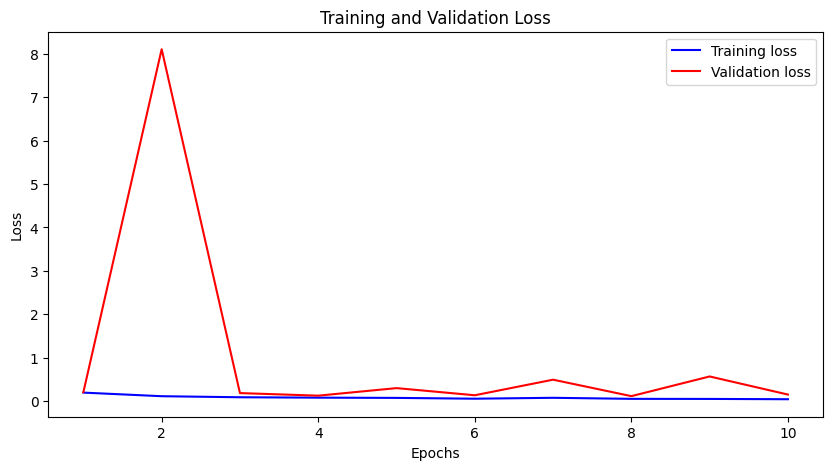

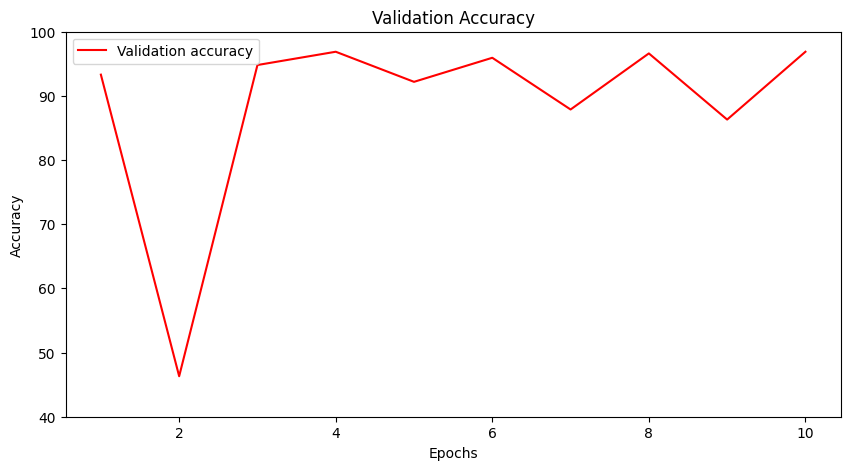

In [14]:
import matplotlib.pyplot as plt

train_losses = [0.1916, 0.1086, 0.0844, 0.0752, 0.0697, 0.0511, 0.0719, 0.0477, 0.0459, 0.0391]
val_losses = [0.2017, 8.1095, 0.1805, 0.1211, 0.2952, 0.1304, 0.4896, 0.1100, 0.5639, 0.1468]
train_accuracies = [None] * 10  # 훈련 정확도 로그가 없으므로 None으로 처리
val_accuracies = [93.31, 46.31, 94.81, 96.88, 92.19, 95.94, 87.88, 96.62, 86.31, 96.88]

epochs = range(1, 11)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
# plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(40, 100)  # y축 범위를 40%에서 100%로 설정하여 변화를 더 잘 보이게 함
plt.show()